## Plant seedling classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
from fastai.conv_learner import *
from sklearn.metrics import confusion_matrix

In [3]:
PATH = 'data/plant-seedlings-classification/'

In [4]:
classes = os.listdir(f'{PATH}train')
#ls {PATH}train

## Multi-label versus single-label classification

In [5]:
from fastai.plots import *

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

In [7]:
def get_rnd(path): xs = glob(f'{path}/*.*'); return xs[random.randint(0, len(xs) - 1)]

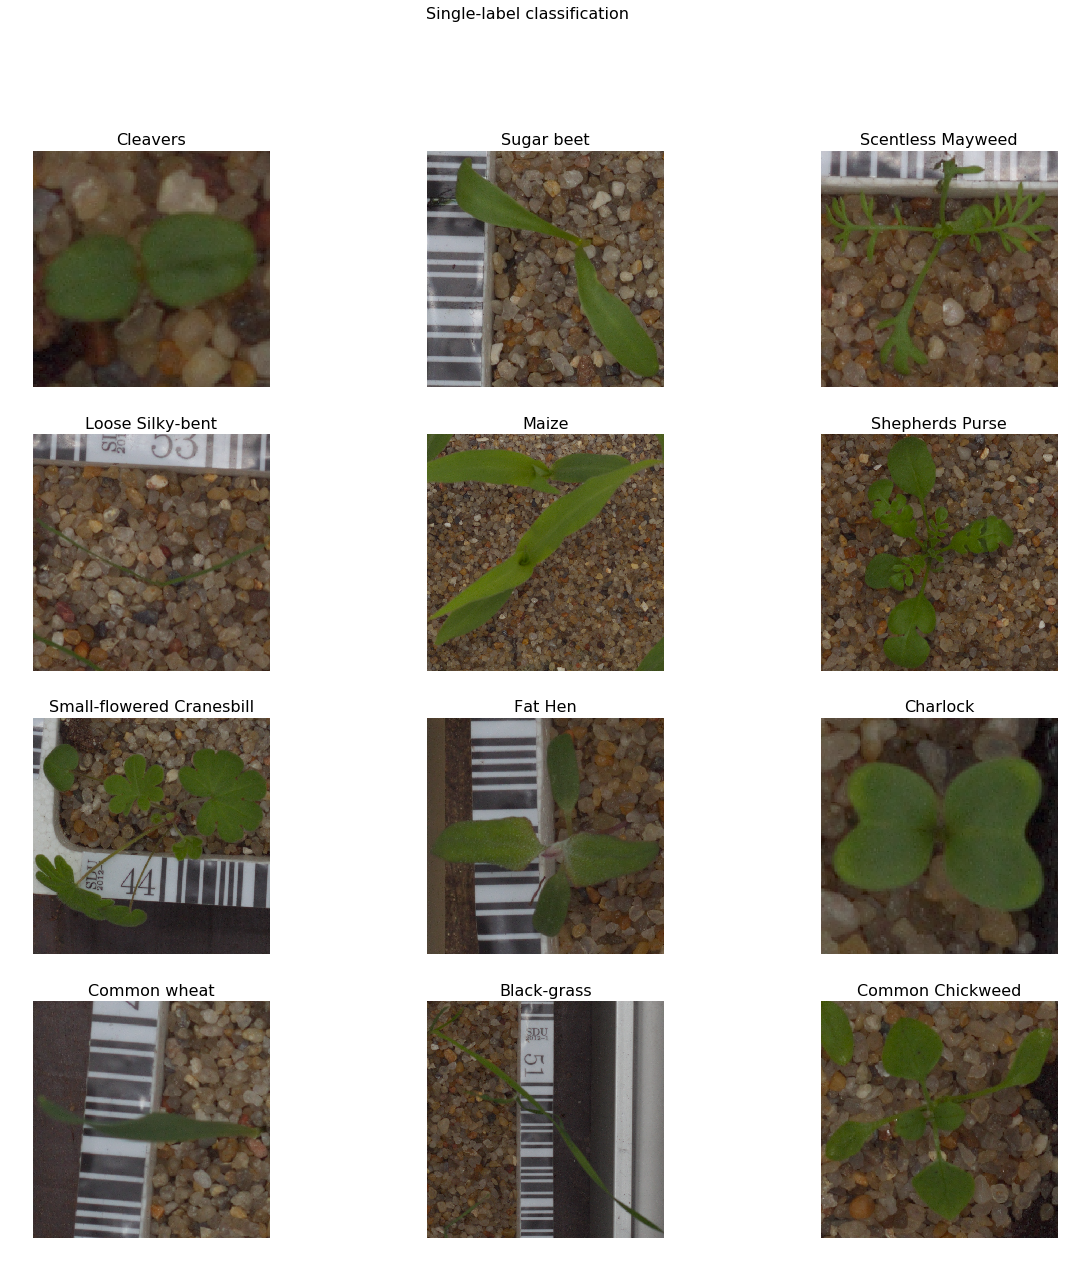

In [8]:
dc_path = "data/plant-seedlings-classification/train/"
list_paths = [get_rnd(PATH + 'train/' + x) for x in classes]
plots_from_files(list_paths, titles=classes, maintitle="Single-label classification", rows=4, figsize=(20, 20))

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

In [9]:
def get_val(PATH, classes):
    """
    generate validation set, use once only!
    """
    for c in classes:
        vpath = f'{PATH}valid/{c}/'.replace(' ', '\\ ')
        !mkdir -p {vpath}
        xs = np.array(glob(f'{PATH}train/{c}/*.*'))
        n = len(xs)
        val_idxs = get_cv_idxs(n)
        for f in xs[val_idxs]:
            g = f.replace(' ', '\\ ')
            h = g.replace('train', 'valid')
            !mv {g} {h}

In [68]:
for c in classes:
    vpath = f'{PATH}valid/{c}/'
    tpath = f'{PATH}train/{c}/'
    print(len(glob(vpath + '/*.*')) / len(glob(tpath + '/*.*')))

0.24782608695652175
0.25
0.24939467312348668
0.2480916030534351
0.24858757062146894
0.24864864864864866
0.24937027707808565
0.25
0.25
0.24858757062146894
0.24644549763033174
0.24948875255623723


In [10]:
#arch = resnet34
arch = resnet50
sz = 64

In [11]:
def getdata(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')

In [12]:
data = getdata(sz)

In [13]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([2423., 1019.,  234.,   97.,   16.,    6.,    3.,    3.,    1.,    1.]),
 array([  49. ,  409.3,  769.6, 1129.9, 1490.2, 1850.5, 2210.8, 2571.1, 2931.4, 3291.7, 3652. ]),
 <a list of 10 Patch objects>)

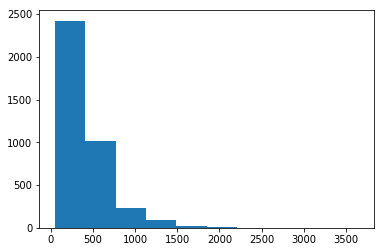

In [14]:
plt.hist(row_sz)

(array([991., 821., 278., 410., 386., 270., 197., 120.,  75.,  59.]),
 array([ 49. , 143.4, 237.8, 332.2, 426.6, 521. , 615.4, 709.8, 804.2, 898.6, 993. ]),
 <a list of 10 Patch objects>)

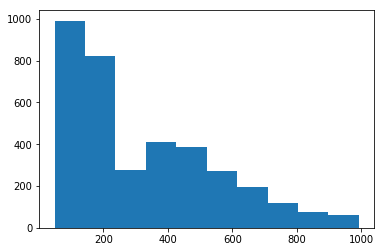

In [15]:
plt.hist(row_sz[row_sz < 1000])

In [17]:
learn = ConvLearner.pretrained(arch, data)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 92%|█████████▏| 55/60 [00:07<00:00,  6.89it/s, loss=11.6]


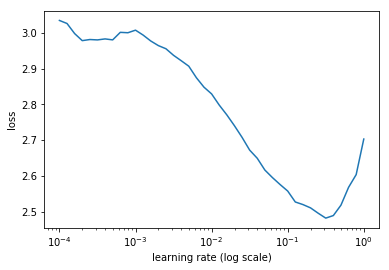

In [18]:
lrf = learn.lr_find()
learn.sched.plot()

In [19]:
lr = 0.1

In [20]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.023201   1.359815   0.517872  
    1      1.789087   1.310752   0.53895                  
    2      1.476858   1.156977   0.606679                 
    3      1.43384    1.209279   0.574918                 
    4      1.31592    1.123117   0.599918                 
    5      1.206267   1.049706   0.634293                 
    6      1.128289   1.052716   0.631944                 



[1.0527165, 0.6319444457689921]

In [21]:
lrs = np.array([lr/9, lr/3, lr])

In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.211544   0.799092   0.704616  
    1      0.926237   0.551302   0.803084                  
    2      0.641454   0.412123   0.854391                  
    3      0.618037   0.574654   0.790074                  
    4      0.49352    0.483983   0.834334                  
    5      0.408484   0.326315   0.877042                  
    6      0.312878   0.29353    0.895792                  



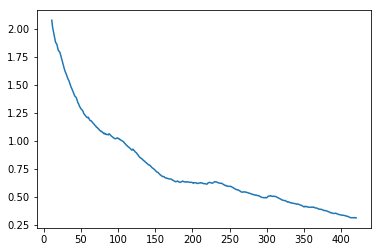

In [23]:
learn.sched.plot_loss()

In [24]:
sz = 128
learn.set_data(getdata(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.612019   0.492615   0.837194  
    1      0.570703   0.41907    0.853595                  
    2      0.501636   0.392822   0.868444                  
    3      0.494523   0.430714   0.85047                   
    4      0.464819   0.368262   0.871569                  
    5      0.43033    0.335787   0.876777                  
    6      0.396268   0.335064   0.87886                   



[0.33506373, 0.8788602948188782]

In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.457409   0.280463   0.905964  
    1      0.433132   0.34991    0.880699                  
    2      0.304002   0.240946   0.914563                  
    3      0.334725   0.385097   0.842688                  
    4      0.290778   0.239373   0.91924                   
    5      0.204775   0.187925   0.941136                  
    6      0.164921   0.165342   0.943219                  



In [26]:
sz = 256
learn.set_data(getdata(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.306027   0.252313   0.921324  
    1      0.276089   0.224297   0.929922                  
    2      0.238441   0.204167   0.940605                  
    3      0.236502   0.212598   0.930188                  
    4      0.23045    0.198599   0.939828                  
    5      0.206464   0.196397   0.940605                  
    6      0.182027   0.19025    0.94087                   



[0.19024964, 0.9408700982729594]

In [27]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.364385   0.245238   0.912214  
    1      0.287188   0.382387   0.884355                  
    2      0.197523   0.162652   0.952594                  
    3      0.197137   0.395556   0.872651                  
    4      0.183879   0.242504   0.92498                   
    5      0.139761   0.150215   0.953636                  
    6      0.108822   0.149263   0.957292                  



In [35]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9588173178458289, 0.13957022967509972)

In [39]:
preds = np.argmax(probs, axis=1)

[[ 41   0   0   0   3   0   8   0   0   0   0   0]
 [  0  73   2   0   0   1   0   0   0   1   0   1]
 [  0   0  57   0   0   0   0   0   0   0   0   0]
 [  0   0   0 120   0   0   0   0   2   0   0   0]
 [  0   0   0   0  44   0   0   0   0   0   0   0]
 [  0   0   0   0   1  94   0   0   0   0   0   0]
 [  8   0   0   0   0   0 122   0   0   0   0   0]
 [  0   0   0   0   1   0   0  42   1   0   0   0]
 [  0   0   0   0   0   0   1   0 100   2   0   0]
 [  0   0   0   0   0   0   0   0   6  40   0   0]
 [  0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   0   0   0   0   0   1   0   0   0   0  76]]


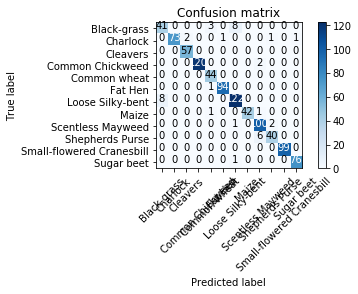

In [40]:
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [29]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), axis=0)

(794, 12)

In [30]:
preds = np.argmax(probs, axis=1)
preds_c = [data.classes[x] for x in preds]

In [31]:
testnames = [s[5:] for s in data.test_ds.fnames]
df = pd.DataFrame({'file': testnames, 'species': preds_c})
df.to_csv(PATH + 'submit.csv', index=False)

In [33]:
!kaggle competitions submit -c plant-seedlings-classification -f data/plant-seedlings-classification/submit.csv -m 'second submission with fastai'

Successfully submitted to Plant Seedlings Classification